# Sentinel Hub Process API

Test de recuparation d'aimmage a partir de coordonnés lat/lng + superposition d'images

https://stackoverflow.com/questions/238260/how-to-calculate-the-bounding-box-for-a-given-lat-lng-location

In [1]:
from sentinelhub import SHConfig

config = SHConfig(
    sh_client_id = "655ff33c-6a71-495c-8241-0c8e97d6f31f",
    sh_client_secret = "QyE4D6EfWyMa1SUL6QfCANJoM6V0LqQC"
)

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import math

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    WmsRequest
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

# Divide a Bbox in a list of points

In [4]:
from geopy.distance import distance
from geopy.point import Point

# Fonction pour déplacer les coordonnées selon une distance et une direction données
def move_coords(longitude, latitude, dist, dir):
    initial_point = Point(latitude, longitude)
    new_point = distance(kilometers=dist).destination(initial_point, dir)
    new_latitude = new_point.latitude
    new_longitude = new_point.longitude
    return new_latitude, new_longitude

def generate_grid_within_box(lat_min, lon_min, lat_max, lon_max, spacing_km):
    points = []
    num_lines = 0
    max_points_in_line = 0

    # Point de départ (coin supérieur gauche de la boîte)
    current_lat = lat_max
    current_lon = lon_min

    while current_lat >= lat_min:
        num_lines += 1
        points_in_line = 0
        line_points = []

        while current_lon <= lon_max:
            line_points.append((current_lat, current_lon))
            points_in_line += 1
            # Se déplacer de 40 km vers l'est
            current_lat, current_lon = move_coords(current_lon, current_lat, spacing_km, 90)
        
        points.extend(line_points)
        max_points_in_line = max(max_points_in_line, points_in_line)
        
        # Imprimer le nombre de points pour cette ligne
        print("Nombre de points pour la ligne {}: {}".format(num_lines, points_in_line))
        
        # Se déplacer de 40 km vers le sud
        current_lat, current_lon = move_coords(lon_min, current_lat, spacing_km, 180)

        # Réinitialiser la longitude au bord ouest de la boîte
        current_lon = lon_min
    
    return points, max_points_in_line, num_lines

# Coordonnées de la boîte (coin inférieur gauche et coin supérieur droit)
#(-120.28051362246235, 51.34052433805592, -119.11857712290127, 52.06065880190754)
lat_min = 51.34052433805592
lon_min = -120.28051362246235
lat_max = 52.06065880190754
lon_max = -119.11857712290127

# Espacement souhaité en kilomètres
spacing_km = 10

# Générer les points et obtenir le nombre de points par ligne et le nombre de lignes
points, max_points_in_line, num_lines = generate_grid_within_box(lat_min, lon_min, lat_max, lon_max, spacing_km)

#inverse lon et lat
points = [(y,x) for x,y in points]

# Afficher les résultats
print("Nombre de points par ligne : ", max_points_in_line)
print("Nombre de lignes : ", num_lines)
print("Points générés :")
for point in points:
    print(point)
len(points)






Nombre de points pour la ligne 1: 8
Nombre de points pour la ligne 2: 8
Nombre de points pour la ligne 3: 9
Nombre de points pour la ligne 4: 9
Nombre de points pour la ligne 5: 9
Nombre de points pour la ligne 6: 9
Nombre de points pour la ligne 7: 9
Nombre de points pour la ligne 8: 9
Nombre de points par ligne :  9
Nombre de lignes :  8
Points générés :
(-120.28051362246235, 52.06065880190754)
(-120.13470966284945, 52.06056861666617)
(-119.98890599687455, 52.0604784317157)
(-119.84310262453516, 52.06038824705614)
(-119.6972995458288, 52.06029806268747)
(-119.55149676075295, 52.0602078786097)
(-119.40569426930514, 52.06011769482283)
(-119.25989207148287, 52.06002751132685)
(-120.28051362246235, 51.97006393673472)
(-120.13500385634163, 51.96997404312861)
(-119.98949438136523, 51.96988414981127)
(-119.8439851975307, 51.96979425678273)
(-119.69847630483557, 51.969704364042975)
(-119.55296770327737, 51.96961447159201)
(-119.40745939285367, 51.96952457942984)
(-119.26195137356197, 51.9694

70

# Find a bbox with coordinate :

In [5]:
# degrees to radians
def deg2rad(degrees):
    return math.pi*degrees/180.0
# radians to degrees
def rad2deg(radians):
    return 180.0*radians/math.pi

# Semi-axes of WGS-84 geoidal reference
WGS84_a = 6378137.0  # Major semiaxis [m]
WGS84_b = 6356752.3  # Minor semiaxis [m]

# Earth radius at a given latitude, according to the WGS-84 ellipsoid [m]
def WGS84EarthRadius(lat):
    # http://en.wikipedia.org/wiki/Earth_radius
    An = WGS84_a*WGS84_a * math.cos(lat)
    Bn = WGS84_b*WGS84_b * math.sin(lat)
    Ad = WGS84_a * math.cos(lat)
    Bd = WGS84_b * math.sin(lat)
    return math.sqrt( (An*An + Bn*Bn)/(Ad*Ad + Bd*Bd) )

# Bounding box surrounding the point at given coordinates,
# assuming local approximation of Earth surface as a sphere
# of radius given by WGS84
def boundingBox(longitudeInDegrees, latitudeInDegrees, halfSideInKm):
    lat = deg2rad(latitudeInDegrees)
    lon = deg2rad(longitudeInDegrees)
    halfSide = 1000*halfSideInKm

    # Radius of Earth at given latitude
    radius = WGS84EarthRadius(lat)
    # Radius of the parallel at given latitude
    pradius = radius*math.cos(lat)

    latMin = lat - halfSide/radius
    latMax = lat + halfSide/radius
    lonMin = lon - halfSide/pradius
    lonMax = lon + halfSide/pradius

    return (rad2deg(lonMin),rad2deg(latMin) ,rad2deg(lonMax) ,rad2deg(latMax) )

# Find every Bbox for each coordinate and set the resolution :

In [6]:
resolution = 50

#for each point create a aoi_bbox with aoi cords of 5km:
aoi_bbox_list = []
for point in points:
    aoi_coords_wgs842 = boundingBox(point[0],point[1],5)
    aoi_bbox_list.append(BBox(bbox=aoi_coords_wgs842, crs=CRS.WGS84))

aoi_size = bbox_to_dimensions(aoi_bbox_list[1], resolution=resolution)
print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")   

Image shape at 50 m resolution: (193, 208) pixels


In [7]:
# Afficher la liste de aoi_bbox
#aoi_bbox_list


# Definition des parametres pour sentinel + fonction de récupération de chaque images : 

In [8]:
evalscript_ndvi = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 4
    }
  }
}

function evaluatePixel(sample) {
    let val = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
    let imgVals = null;
    
    if (val<-1.1) imgVals = [0,0,0];
    else if (val<-0.2) imgVals = [0.75,0.75,0.75];
    else if (val<-0.1) imgVals = [0.86,0.86,0.86];
    else if (val<0) imgVals = [1,1,0.88];
    else if (val<0.025) imgVals = [1,0.98,0.8];
    else if (val<0.05) imgVals = [0.93,0.91,0.71];
    else if (val<0.075) imgVals = [0.87,0.85,0.61];
    else if (val<0.1) imgVals = [0.8,0.78,0.51];
    else if (val<0.125) imgVals = [0.74,0.72,0.42];
    else if (val<0.15) imgVals = [0.69,0.76,0.38];
    else if (val<0.175) imgVals = [0.64,0.8,0.35];
    else if (val<0.2) imgVals = [0.57,0.75,0.32];
    else if (val<0.25) imgVals = [0.5,0.7,0.28];
    else if (val<0.3) imgVals = [0.44,0.64,0.25];
    else if (val<0.35) imgVals = [0.38,0.59,0.21];
    else if (val<0.4) imgVals = [0.31,0.54,0.18];
    else if (val<0.45) imgVals = [0.25,0.49,0.14];
    else if (val<0.5) imgVals = [0.19,0.43,0.11];
    else if (val<0.55) imgVals = [0.13,0.38,0.07];
    else if (val<0.6) imgVals = [0.06,0.33,0.04];
    else imgVals = [0,0.27,0];
    
    imgVals.push(sample.dataMask)
    
    return imgVals
}
"""

#fonction qui configure la requete sentinel (request_ndvi_img) et get_data (ndvi_img):

def get_ndvi_img(aoi_bbox,aoi_size):
    
  request_ndvi_img = SentinelHubRequest(
      evalscript=evalscript_ndvi,
      input_data=[
          SentinelHubRequest.input_data(
              data_collection=DataCollection.SENTINEL2_L2A,
              time_interval=("2022-05-01", "2022-05-07"),
              other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
          )
      ],
      responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
      bbox=aoi_bbox,
      size=aoi_size,
      config=config,   
  )

  ndvi_img = request_ndvi_img.get_data()
  return ndvi_img


In [9]:
#utiliser la fonction get_ndvi_img sur tous les points de la liste de points
ndvi_img_list = []
for aoi_bbox in aoi_bbox_list:
    ndvi_img = get_ndvi_img(aoi_bbox,aoi_size)
    ndvi_img_list.append(ndvi_img)




In [10]:
#regarder la shape des images
for ndvi_img in ndvi_img_list:
    print(ndvi_img[0].shape)

#compter le nombre d'images
print(len(ndvi_img_list))

(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
(208, 193, 4)
70


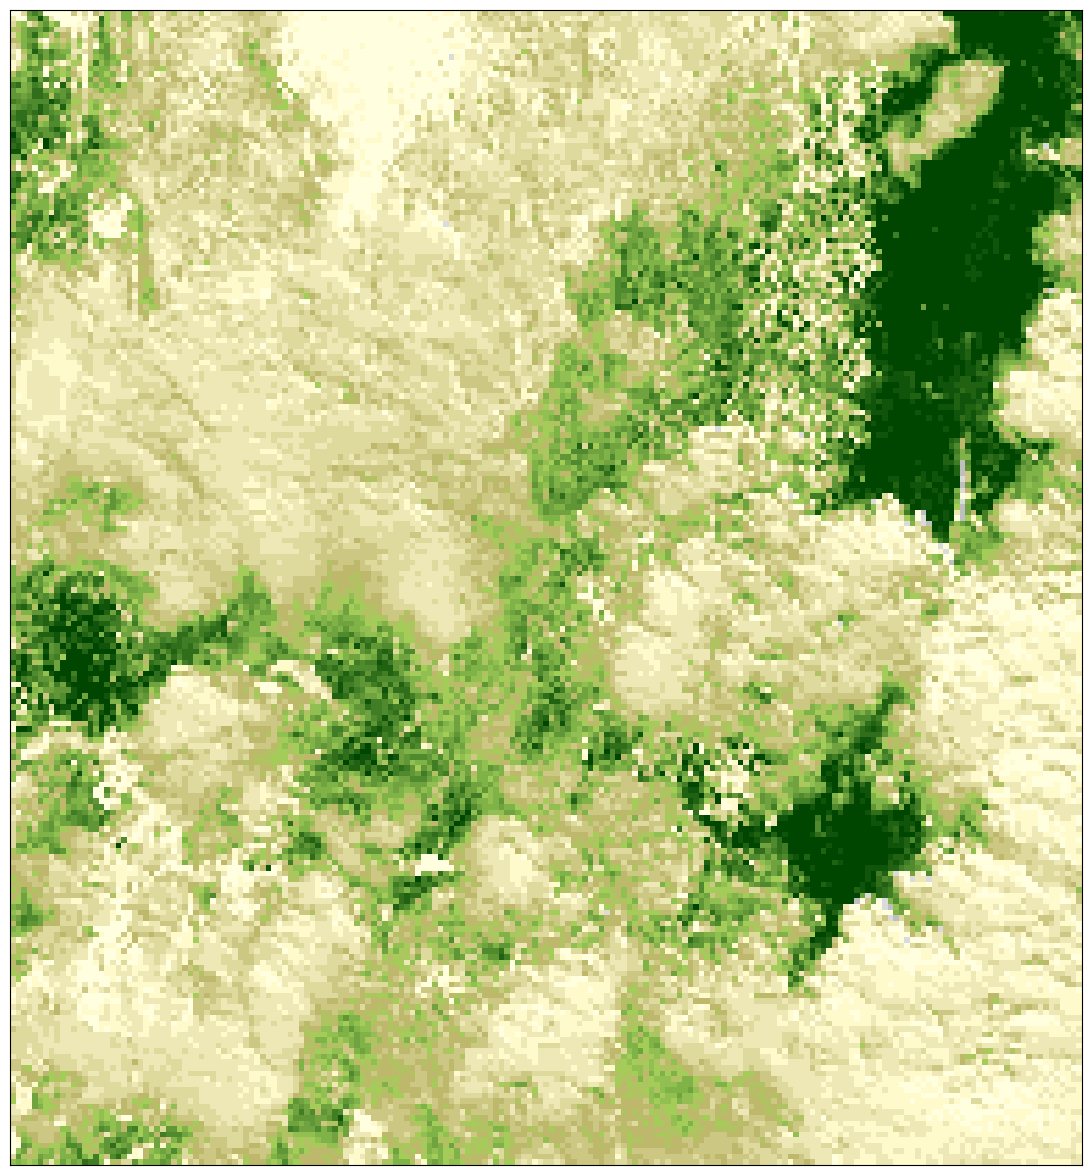

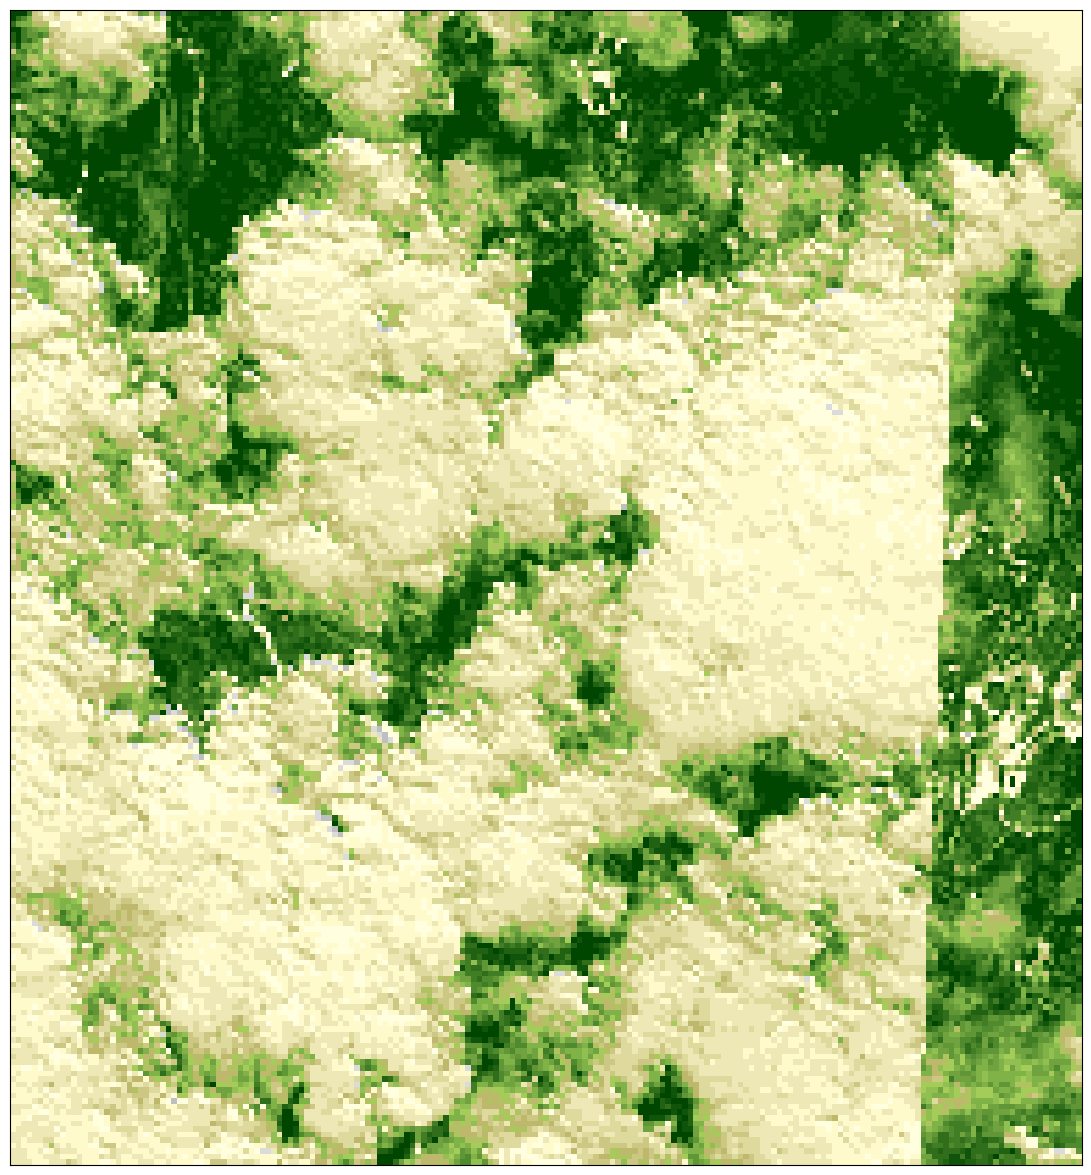

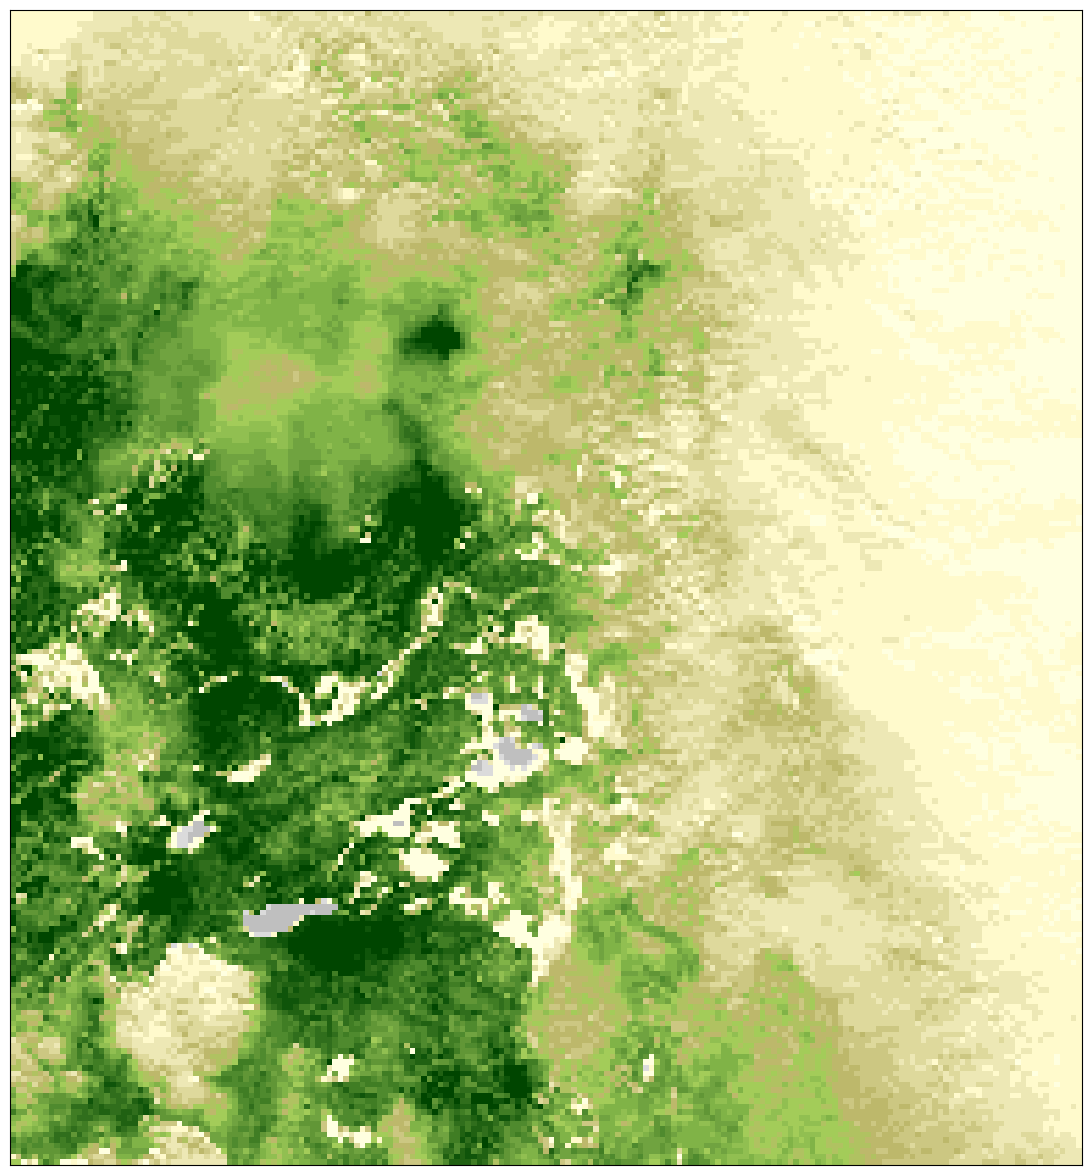

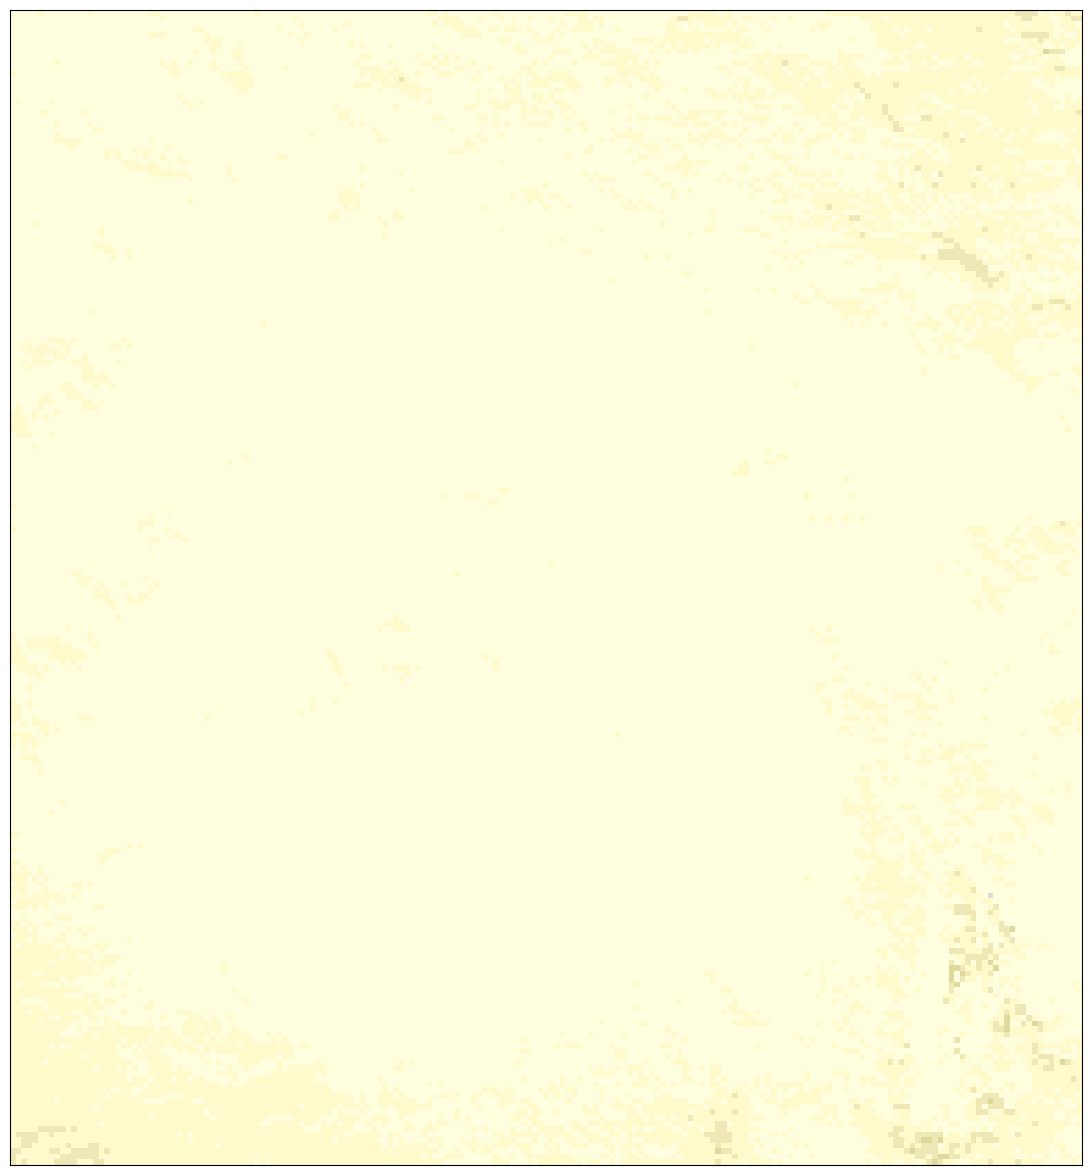

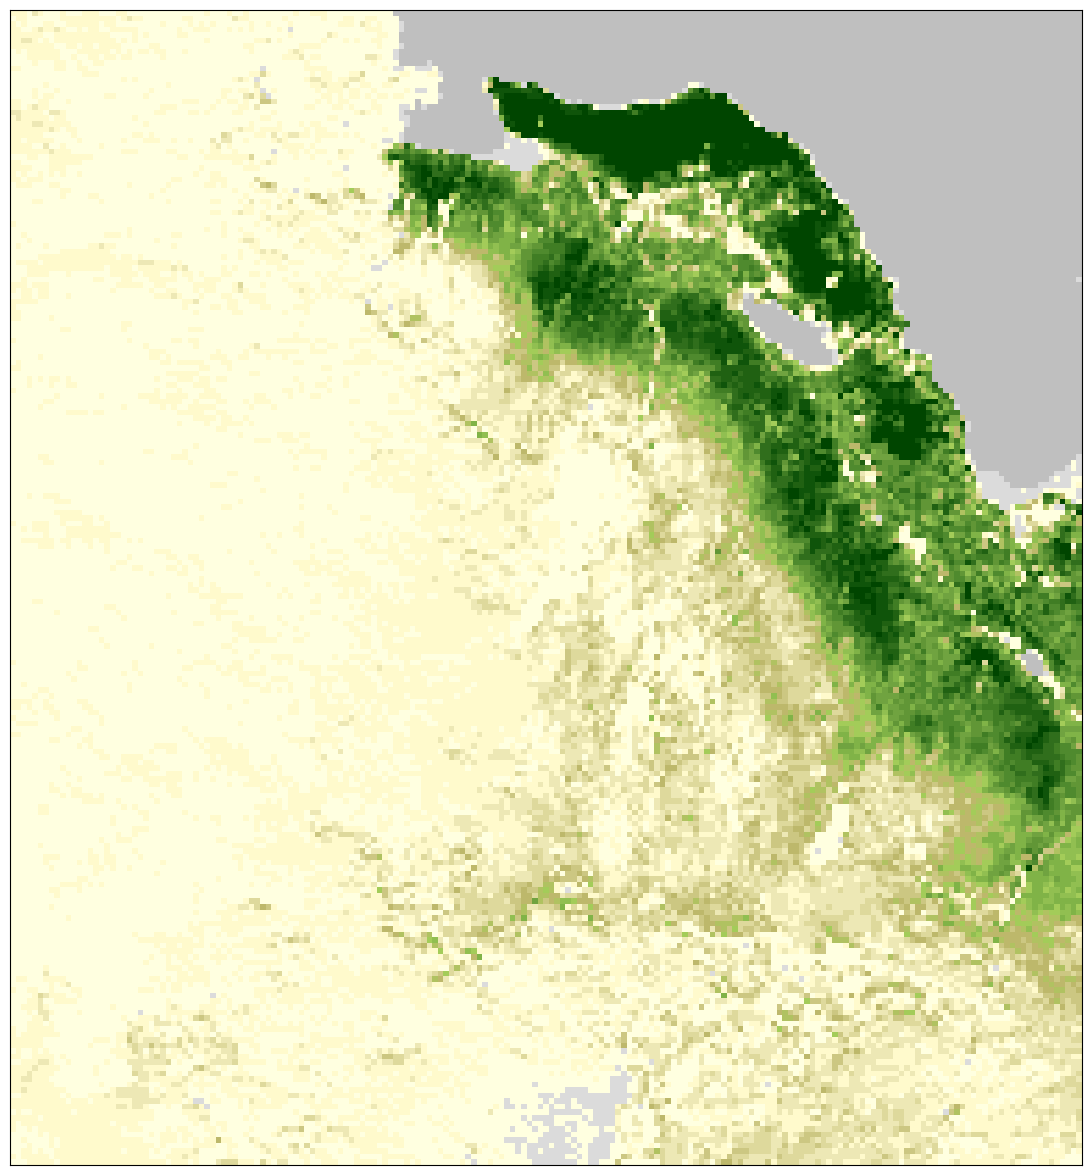

In [11]:
#afficher les 5 premiere images
for i in range(5):
    plot_image(ndvi_img_list[i][0], factor=1 / 255)



    

# Concatenate all images (not finish)

(1, 208, 1351, 4)
(1, 208, 1351, 4)
(1, 208, 1544, 4)
(1, 208, 1544, 4)
(1, 208, 1544, 4)
(1, 208, 1544, 4)
(1, 208, 1544, 4)
(1, 208, 1544, 4)


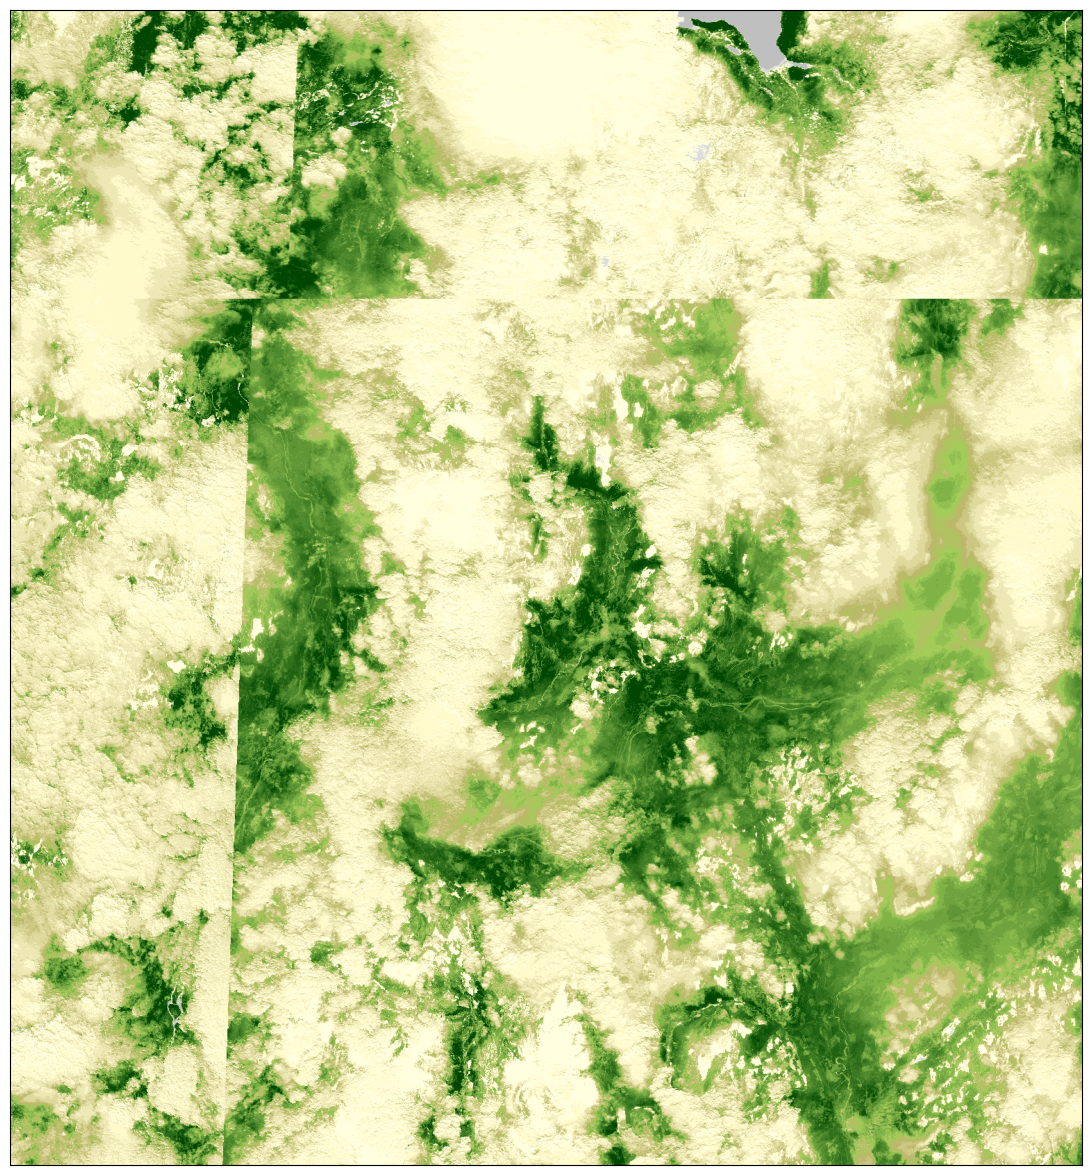

In [12]:
import cv2

#compiler en ligne les 9 premiere immages avec concatenate : 
ndvi_img_list_concat1 = np.concatenate(ndvi_img_list[0:7], axis=2)
ndvi_img_list_concat2 = np.concatenate(ndvi_img_list[8:15], axis=2)
ndvi_img_list_concat3 = np.concatenate(ndvi_img_list[16:24], axis=2)
ndvi_img_list_concat4 = np.concatenate(ndvi_img_list[25:33], axis=2)
ndvi_img_list_concat5 = np.concatenate(ndvi_img_list[34:42], axis=2)
ndvi_img_list_concat6 = np.concatenate(ndvi_img_list[43:51], axis=2)
ndvi_img_list_concat7 = np.concatenate(ndvi_img_list[52:60], axis=2)
ndvi_img_list_concat8 = np.concatenate(ndvi_img_list[61:69], axis=2)

print(ndvi_img_list_concat1.shape)
print(ndvi_img_list_concat2.shape)
print(ndvi_img_list_concat3.shape)
print(ndvi_img_list_concat4.shape)
print(ndvi_img_list_concat5.shape)
print(ndvi_img_list_concat6.shape)
print(ndvi_img_list_concat7.shape)
print(ndvi_img_list_concat8.shape)

target_size = ndvi_img_list_concat3.shape[2], ndvi_img_list_concat3.shape[1]

def resize_images(ndvi_img_list, target_size):
    resized_images = []
    for img in ndvi_img_list:
        resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        resized_images.append(resized_img)
    return resized_images

ndvi_img_list_concat1 = resize_images(ndvi_img_list_concat1, target_size)
ndvi_img_list_concat2 = resize_images(ndvi_img_list_concat2, target_size)
ndvi_img_list_concat3 = resize_images(ndvi_img_list_concat3, target_size)
ndvi_img_list_concat4 = resize_images(ndvi_img_list_concat4, target_size)
ndvi_img_list_concat5 = resize_images(ndvi_img_list_concat5, target_size)
ndvi_img_list_concat6 = resize_images(ndvi_img_list_concat6, target_size)
ndvi_img_list_concat7 = resize_images(ndvi_img_list_concat7, target_size)
ndvi_img_list_concat8 = resize_images(ndvi_img_list_concat8, target_size)


#concatener chaquel ligne en une seule image
ndvi_img_list_final = np.concatenate((ndvi_img_list_concat1,ndvi_img_list_concat2,ndvi_img_list_concat3,ndvi_img_list_concat4,ndvi_img_list_concat5,ndvi_img_list_concat6,ndvi_img_list_concat7,ndvi_img_list_concat8), axis=1)
#ecrire toutles liste de concat en comentaire sur une ligne sepraré par des virgules

plot_image(ndvi_img_list_final[0], factor=1 / 255)




##  In the visualisation, the lighter greens indicate a higher NDVI value (vegetation, forest) and the darker greens (urban areas and water bodies) represent areas with lower NDVI values.